In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

def map_y(y):
    if y >= 3400:
        return 4.0
    elif y >= 1800:
        return 3.0
    elif y >= 1200:
        return 2.0
    elif y >= 800:
        return 1.0
    else:
        return 0.0

df = pd.read_csv('../datasets/news-popularity.csv').sample(frac=1)
df = df.drop(columns=["url"])
xy = df.to_numpy()
x = xy[:,1:-1] # remove the first feature as it is not predictive
y = xy[:,-1]
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
y = np.array([map_y(i) for i in y]).reshape((len(x), 1))

aux_target_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

2022-03-31 13:52:43.620828: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-31 13:52:43.620937: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpd0
2022-03-31 13:52:43.620960: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpd0
2022-03-31 13:52:43.621229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-31 13:52:43.621299: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-31 13:52:43.621318: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-03-31 13:52:43.622450: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

In [4]:
news_dsa = {}
log_news_dsa = {}

for split in [2,3,4]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=58, class_num=5, split=split, units=256, ed_act="sigmoid")
    news_dsa[split] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log_news_dsa[split] = news_dsa[split].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(),
        batch_size=32,
        iterations=1000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.001,
        lr_c=0.001,
        verbose=True,
        log_freq=200)

======Split level is 2======
Iteration 200, train accuracy: 0.25804163366556165, average attack MSE: 0.055303279962390664
Iteration 400, train accuracy: 0.27380333706736565, average attack MSE: 0.051866071969270705
Iteration 600, train accuracy: 0.2796489356458187, average attack MSE: 0.05214706992730498
Iteration 800, train accuracy: 0.28213895425200464, average attack MSE: 0.05188408676534891
Iteration 1000, train accuracy: 0.28484512761235237, average attack MSE: 0.052001609336584806
======Split level is 3======
Iteration 200, train accuracy: 0.25409031949937344, average attack MSE: 0.05593424079939723
Iteration 400, train accuracy: 0.27619687244296076, average attack MSE: 0.052014557644724846
Iteration 600, train accuracy: 0.27980920985341073, average attack MSE: 0.05184884143993258
Iteration 800, train accuracy: 0.28247795045375823, average attack MSE: 0.05199019221588969
Iteration 1000, train accuracy: 0.28417992338538167, average attack MSE: 0.05174316687509418
======Split level

In [6]:
from fsha import *

news_fsha={}
log_news_fsha={}

for split in [4,3,2]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    hparams = {
        'WGAN' : False,
        'style_loss' : None,
        'lr_f' :  0.001,
        'lr_tilde': 0.001,
        'lr_D': 0.001,
        'lr_g': 0.001
    }
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=58, class_num=5, split=split, units=256, ed_act="sigmoid")
    models = (make_f, make_g, make_e, make_d, make_c)
    news_fsha[split] = FSHA(
        target_ds, aux_ds,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(), models=models, batch_size=32, hparams=hparams)
    log_news_fsha[split]=news_fsha[split](1000, verbose=True, progress_bar=False, log_frequency=200)

======Split level is 4======
RUNNING...
Iteration 0000000 train accuracy: 0.0938, validation: 0.2027
Iteration 0000200 train accuracy: 0.2200, validation: 0.0550
Iteration 0000400 train accuracy: 0.2140, validation: 0.0520
Iteration 0000600 train accuracy: 0.2116, validation: 0.0518
Iteration 0000800 train accuracy: 0.2078, validation: 0.0519
======Split level is 3======
RUNNING...
Iteration 0000000 train accuracy: 0.0625, validation: 0.1905
Iteration 0000200 train accuracy: 0.2166, validation: 0.0550
Iteration 0000400 train accuracy: 0.2055, validation: 0.0521
Iteration 0000600 train accuracy: 0.2098, validation: 0.0520
Iteration 0000800 train accuracy: 0.2133, validation: 0.0521
======Split level is 2======
RUNNING...
Iteration 0000000 train accuracy: 0.1562, validation: 0.1831
Iteration 0000200 train accuracy: 0.2169, validation: 0.0550
Iteration 0000400 train accuracy: 0.2157, validation: 0.0519
Iteration 0000600 train accuracy: 0.2159, validation: 0.0519
Iteration 0000800 train ac

In [7]:
with open('log/news-dsa.pkl', 'wb') as f:
    pickle.dump(log_news_dsa, f)
with open('log/news-fsha.pkl', 'wb') as f:
    pickle.dump(log_news_fsha, f)

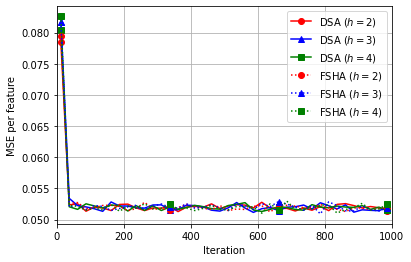

In [8]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 25
# plt.yscale('logit')
plt.xlim([0,1000])
plt.grid()

sampled_loss = {}
sampled_fsha_loss = {}

for split in [2,3,4]:
    sampled_loss[split] = [sum(log_news_dsa[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_dsa[split][:,0])/log_freq))]
    sampled_fsha_loss[split] = [sum(log_news_fsha[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(1000/log_freq))]
plt.ylabel('MSE per feature')
plt.xlabel('Iteration')
plt.plot(ran, sampled_loss[2], 'ro-', ran, sampled_loss[3], 'b^-', ran, sampled_loss[4], 'gs-', markevery=13)
plt.plot(ran, sampled_fsha_loss[2], 'ro:', ran, sampled_fsha_loss[3], 'b^:', ran, sampled_fsha_loss[4], 'gs:', markevery=13)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/news.pdf", bbox_inches='tight')

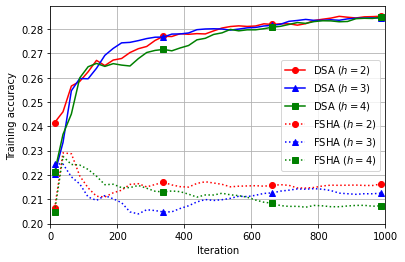

In [9]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 25
# plt.yscale('logit')
plt.xlim([0,1000])
plt.grid()

sampled_acc = {}
sampled_fsha_acc = {}

for split in [2,3,4]:
    sampled_acc[split] = [sum(log_news_dsa[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_dsa[split][:,0])/log_freq))]
    sampled_fsha_acc[split] = [sum(log_news_fsha[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(1000/log_freq))]
plt.ylabel('Training accuracy')
plt.xlabel('Iteration')
plt.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=13)
plt.plot(ran, sampled_fsha_acc[2], 'ro:', ran, sampled_fsha_acc[3], 'b^:', ran, sampled_fsha_acc[4], 'gs:', markevery=13)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.ylabel('Training accuracy')
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/news-acc.pdf", bbox_inches='tight')

In [19]:
split=4
news_dsa_size = {}
log_news_dsa_size = {}

make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=58, class_num=5, split=split, units=256, ed_act="sigmoid")

for size in [1,5,10,20,50]:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=42)
    
    target_ds = make_dataset(x_train, y_train, lambda t: t)
    aux_ds = make_dataset(x_test, y_test, lambda t: t)
    
    news_dsa_size[size] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Auxiliary size is {}======".format(size))
    print("============================")
    log_news_dsa_size[size] = news_dsa_size[size].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(),
        batch_size=32,
        iterations=1000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.001,
        lr_c=0.001,
        verbose=True,
        log_freq=200)

======Auxiliary size is 1======
Iteration 200, train accuracy: 0.25176250621676444, average attack MSE: 0.1089809512346983
Iteration 400, train accuracy: 0.27104048237204553, average attack MSE: 0.11030646778643131
Iteration 600, train accuracy: 0.2753080852329731, average attack MSE: 0.11069656599313021
Iteration 800, train accuracy: 0.27967668905854226, average attack MSE: 0.11189493391662836
Iteration 1000, train accuracy: 0.2825671696662903, average attack MSE: 0.11109832022339106
======Auxiliary size is 5======
Iteration 200, train accuracy: 0.25812931917607784, average attack MSE: 0.06024124028161168
Iteration 400, train accuracy: 0.27394169941544533, average attack MSE: 0.057694013956934215
Iteration 600, train accuracy: 0.2759612162411213, average attack MSE: 0.057831597439944746
Iteration 800, train accuracy: 0.28000170409679415, average attack MSE: 0.05837228270247578
Iteration 1000, train accuracy: 0.28310931608080864, average attack MSE: 0.057857825364917514
======Auxiliary

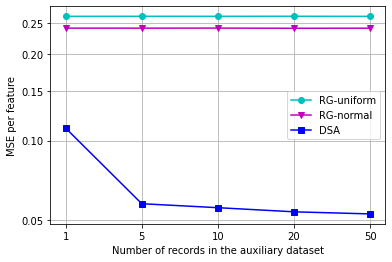

In [22]:
ran = ["1","5","10","20","50"]
rgn = [tf.keras.losses.MeanSquaredError()(np.random.normal(loc=0.5,scale=0.25,size=x.shape),x) for i in ran]
rgu = [tf.keras.losses.MeanSquaredError()(np.random.uniform(low=0,high=1,size=x.shape),x) for i in ran]
mse = [0.111,0.058,0.056,0.054,0.053]
plt.yscale('logit')
plt.grid()
plt.yticks(ticks=[0.05,0.1,0.15,0.2,0.25],labels=["0.05","0.10","0.15","0.20","0.25"])
plt.plot(ran,rgu,'co-',ran,rgn,'mv-',ran,mse,'bs-', markevery=1)
plt.ylabel('MSE per feature')
plt.xlabel('Number of records in the auxiliary dataset')
plt.legend(["RG-uniform", "RG-normal", "DSA"])
plt.savefig("fig/news-size.pdf", bbox_inches='tight')